<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 3 : Groupement hiérarchique de documents

## Résumé
Le but de ce laboratoire est d'appliquer un algorithme de groupement hiérarchique à des résumés de films.  Vous afficherez les résultats et observerez quels paramètres permettent d'obtenir un groupement convenable, car il n'y a pas de vérité-terrain dans ces données.

Les étapes proposées sont les suivantes :
  1. Préparation des documents : pré-traitement des textes des résumés
  2. Création des représentations vectorielles de chaque résumé
  3. Groupement hiérarchique, affichage du dendrogramme, et discussion

## 1. Préparation des documents

Dans ce labo, vous utiliserez les titres et résumés des 100 films classiques (*référence anonymisée*) qui vous sont fournis sur Cyberlearn dans le fichier `movie_data.csv` sur deux colonnes : titres et résumés.

Dans cette première partie, vous allez transformer les textes des résumés pour réduire la diversité du vocabulaire.  Un ensemble de fonctions de préparation vous est fourni dans la librairie `utils.py` (également sur Cyberlearn) et il est conseillé de les lire et de les utiliser.

In [120]:
import pandas as pd
import utils # librairie avec des fonctions de pré-traitement des textes
# elle fait appel à la librairie NLTK (ce qui affiche plusieurs messages)

a. Veuillez charger les données des films depuis le fichier `movie_data.csv` dans une _DataFrame_ intitulée `movie_data`.  Combien de lignes et colonnes a-t-elle et quels sont les intitulés des colonnes ?

In [121]:
import pandas as pd

movie_data = pd.read_csv('data/movie_data.csv')
movie_data.head()

,Title,Synopsis
0,The Godfather,"In late summer 1945, guests are gathered for t..."
1,The Shawshank Redemption,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,Schindler's List,The relocation of Polish Jews from surrounding...
3,Raging Bull,"The film opens in 1964, where an older and fat..."
4,Casablanca,"In the early years of World War II, December 1..."


b. Veuillez normaliser le texte de chaque résumé en appliquant plusieurs des fonctions fournies dans `utils.py` (pour cela, vous devez examiner ce fichier).  Veuillez stocker les textes normalisés dans une nouvelle colonne de la _DataFrame_.   Il n'est pas nécessaire de tokeniser les textes normalisés, car le _vectorizer_ de sklearn le fera plus loin. 

In [122]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

movie_data['normalized'] = (movie_data['Synopsis']
                            .apply(utils.remove_non_alphabetic)
                            .apply(utils.remove_punctuation)
                            .apply(utils.remove_stopwords)
                            .apply(utils.lemmatize_text))
movie_data.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lcsch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\lcsch\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


,Title,Synopsis,normalized
0,The Godfather,"In late summer 1945, guests are gathered for t...",in late summer guest gather wed reception don ...
1,The Shawshank Redemption,"In 1947, Andy Dufresne (Tim Robbins), a banker...",in andy dufresne tim robbins banker maine conv...
2,Schindler's List,The relocation of Polish Jews from surrounding...,the relocation polish jew surround area krakow...
3,Raging Bull,"The film opens in 1964, where an older and fat...",the film open old fatter jake lamotta robert d...
4,Casablanca,"In the early years of World War II, December 1...",in early year world war ii december moroccan c...


c. Veuillez analyser la longueur des résumés, avant et après le pré-traitement, grâce au _5-number summary_ de chaque distribution.  Veuillez commenter brièvement l'évolution de la distribution suite au pré-traitement.

In [123]:
print('>>> Données brutes :\n', movie_data['Synopsis'].apply(len).describe())
print('>>> Après pré-traitement :\n', movie_data['normalized'].apply(len).describe())


>>> Données brutes :
 count      100.000000
mean      8779.840000
std       6603.462185
min       1071.000000
25%       4378.750000
50%       6528.500000
75%      11417.500000
max      34021.000000
Name: Synopsis, dtype: float64
>>> Après pré-traitement :
 count      100.00000
mean      5570.09000
std       4090.04443
min        705.00000
25%       2792.75000
50%       4139.50000
75%       7115.00000
max      21899.00000
Name: normalized, dtype: float64


On peut voir que la longueur moyenne des résumés diminue après le pré-traitement. Pareil pour la médiane.

d. Veuillez afficher un extrait du résumé d'un film *avant* et *après* le pré-traitement et commenter brièvement le résultat.

In [124]:
print('Exemple pour le film "', movie_data['Title'][0], '".')
print('Avant pré-traitement :', movie_data['Synopsis'][0])
print('Après pré-traitement :', movie_data['normalized'][0])

Exemple pour le film " The Godfather ".
Avant pré-traitement : In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter's wedding day." One of the men who asks the Don for a favor is Amerigo Bonasera, a successful mortician and acquaintance of the Don, whose daughter was brutally beaten by two young men because she refused their advances; the men received minimal punishment. The Don is disappointed in Bonasera, who'd avoided most contact with the Don due to Corleone's nefarious business dealings. The Don's wife is godmother to Bonasera's shamed daughter, a relationship the Don uses to extract new loya

## 2. Création des représentations vectorielles

Dans cette partie, vous allez créer pour chaque film une représentation vectorielle avec les coefficients TF-IDF, comme vous l'avez appris en PCD, en utilisant `TfidfVectorizer`.  Veuillez justifier brièvement votre choix de paramètres.

a. Veuillez créer les vecteurs dans un tableau appelé `feature_matrix`, avec autant de lignes que de films.

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, ngram_range=(1,2))

feature_matrix = vectorizer.fit_transform(movie_data['normalized'])

print("Matrice des caractéristiques (feature_matrix) :")
print(feature_matrix.toarray())

Matrice des caractéristiques (feature_matrix) :
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00677592 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


b. Quel est le nombre de colonnes du tableau `feature_matrix`. Pourquoi ?

In [126]:
print(feature_matrix.shape)

(100, 8386)


Il y a 8386 colonnes, car il y a 8386 mots/n-grams différents qui ont été gardés selon les paramètres du TfidfVectorizer.

c. Veuillez afficher les mots correspondant aux 20 premières dimensions de `feature_matrix`.  (Note : les dimensions sont classées par ordre alphabétique des mots.)

In [127]:
vectorizer.get_feature_names_out()[:20]

array(['000', '000 acre', '12', '15', '15 year', '17', '17 year', '1900s',
       '1930s', '1940s', '1950s', '1st', '21', '21 year', '40', '60',
       'aback', 'abandon', 'abandon house', 'abandonment'], dtype=object)

## 3. Groupement hiérarchique
Dans cette section, vous utiliserez un algorithme de groupement hiérarchique et vous afficherez les résultats sous forme de dendrogramme.  Les fonctions utilisées proviendront de `scipy`, comme recommandé par sklearn sous [Plot Hierarchical Clustering Dendrogram](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html).  Merci de suivre les indications et répondre aux questions suivantes.

In [128]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import single, complete, average, ward
from scipy.cluster.hierarchy import dendrogram, cut_tree
import matplotlib.pyplot as plt
%matplotlib inline

a. Générer une matrice des distances entre paires de résumés, en utilisant les représentations vectorielles obtenues ci-dessus et la métrique [sklearn.metrics.pairwise.cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html).  Attention, le cosinus étant une similarité, prendre _1-cosinus_ pour obtenir des distances. 

In [129]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cosine_sim_matrix = cosine_similarity(feature_matrix)
distance_matrix = 1 - cosine_sim_matrix

print('Matrice des distances entre les résumés :\n', distance_matrix)

Matrice des distances entre les résumés :
 [[-6.66133815e-16  9.76287844e-01  9.53175979e-01 ...  9.68373044e-01
   9.30154630e-01  9.61124626e-01]
 [ 9.76287844e-01 -2.22044605e-16  9.52851029e-01 ...  9.69719902e-01
   9.46225429e-01  9.79095516e-01]
 [ 9.53175979e-01  9.52851029e-01 -1.33226763e-15 ...  9.59683560e-01
   9.36900725e-01  9.55810476e-01]
 ...
 [ 9.68373044e-01  9.69719902e-01  9.59683560e-01 ... -6.66133815e-16
   8.73145449e-01  9.80704696e-01]
 [ 9.30154630e-01  9.46225429e-01  9.36900725e-01 ...  8.73145449e-01
  -8.88178420e-16  9.58625324e-01]
 [ 9.61124626e-01  9.79095516e-01  9.55810476e-01 ...  9.80704696e-01
   9.58625324e-01  0.00000000e+00]]


b. Veuillez utiliser la méthode **ward** de [scipy.cluster.hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) qui effectue le groupement hiérarchique à partir d'une matrice des distances.  Quel est le résultat retourné par la méthode ?

In [130]:
from scipy.cluster.hierarchy import ward, complete,single

hierarchy = ward(distance_matrix)

Le résultat obtenu est un 'linkage', soit une représentation du groupement hiérarchique. Nous utiliserons ce linkage pour afficher le dendrogramme.

c. Afficher le dendrogramme avec la fonction [scipy.cluster.hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) qui utilise la matrice de liens.  Utiliser l'exemple donné en bas de la page [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html).  Veuillez afficher un dendrogramme aussi lisible que possible, et en particulier veuillez étiqueter chaque feuille avec le nom du film correspondant.

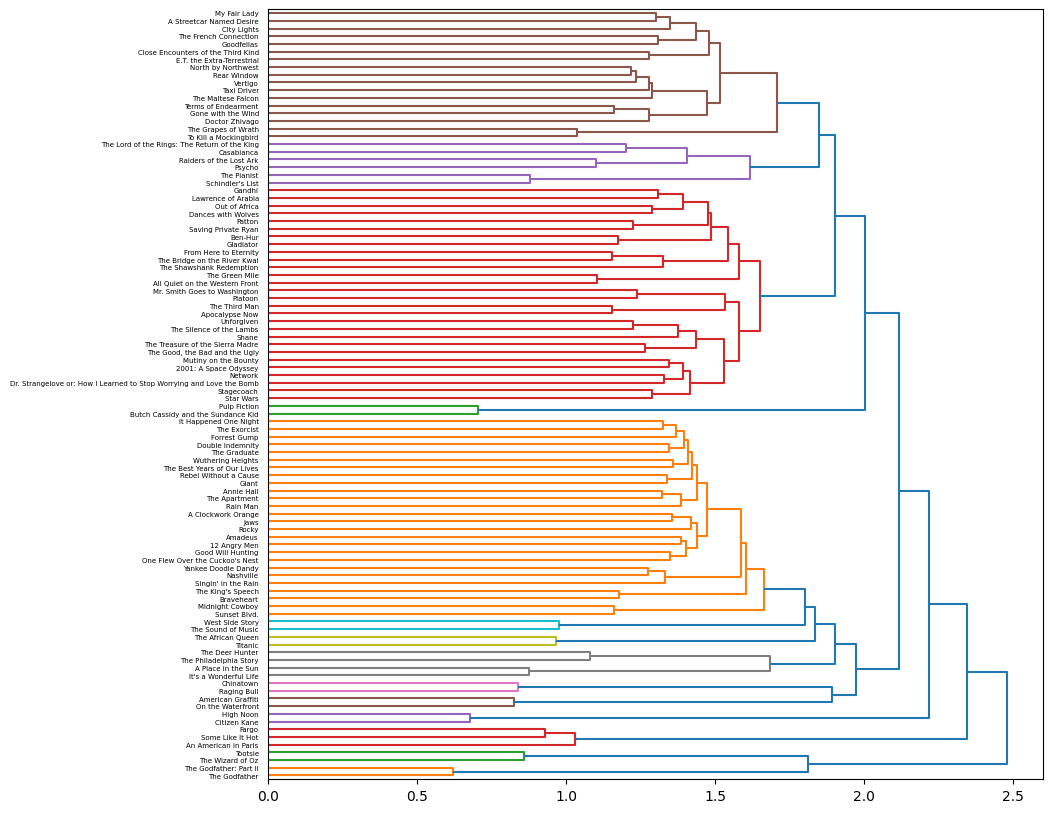

In [131]:
import matplotlib.pyplot as plt

def show_dendrogram(hierarchy):
    fig = plt.figure(figsize=(10,10))
    #0.8 * max(hierarchy[:,2]
    dn = dendrogram(hierarchy, orientation='right', labels=[label for label in movie_data['Title']])
    plt.show()

show_dendrogram(hierarchy)

d. Veuillez essayer une deuxième méthode de groupement hiérarchique et afficher son dendrogramme.  Comment se compare-t-il au précédent ?  Le trouvez-vous meilleur, moins bon, ou similaire ? 

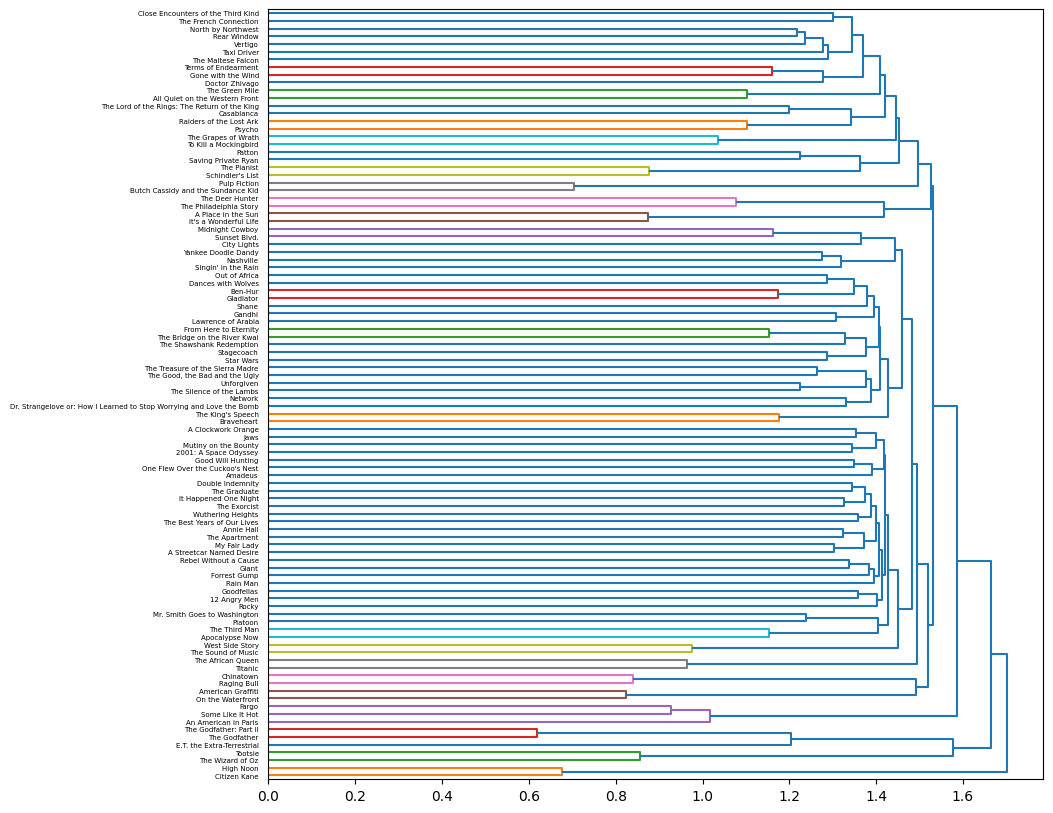

In [132]:
hierarchy2 = complete(distance_matrix)
show_dendrogram(hierarchy2)

*Comparaison:*

On trouve plus de films proches avec Ward qu'avec complete-link.

e. Quel est le nombre de groupes qui vous semble optimal, pour la méthode de votre choix ?  Pourquoi ?

*Difficile à estimer, il y a beaucoup de films et les groupes ne paraissent pas extrêmement pertinents. Il y a aussi beaucoup de films qu'on ne connaît pas dans la liste et tous les rechercher à la main prendrait du temps.*

## 4. Affichage des groupes et de leurs mots-clés

Dans cette section, vous utiliserez la méthode de groupement et le nombre de groupes choisis dans la section précédente.  Pour obtenir un nombre de groupe fixé à l'avance à partir de la matrice *linkage* obtenue au 3b ou 3d, vous pouvez utiliser la fonction `cut_tree`de Scipy. 

a. Pour chaque groupe, veuillez afficher :
* le numéro du groupe (commençant par 1)
* les titres des films du groupe
* le nombre de films dans le groupe

In [133]:
from scipy.cluster.hierarchy import fcluster
from collections import Counter
import numpy as np
import pandas as pd

n_clusters = 5 
clusters = fcluster(hierarchy, t=n_clusters, criterion='maxclust')

movie_data['Cluster'] = clusters

def extract_keywords(clustered_data, top_n=10):
    keywords = {}
    for cluster_id in sorted(clustered_data['Cluster'].unique()):
        cluster_text = clustered_data[clustered_data['Cluster'] == cluster_id]['normalized']
        
        all_words = ' '.join(cluster_text).split()
        
        word_counts = Counter(all_words)
        
        common_words = word_counts.most_common(top_n)
        
        keywords[cluster_id] = [word for word, count in common_words]
        
    return keywords

b. Pour chacun des groupes précédents, veuillez afficher les six meilleurs mots-clés qui le caractérisent.  On définit les mots-clés comme les mots (donc les dimensions résultant du `TfidfVectorizer`) qui ont les plus grands coefficients dans le centre de gravité du groupe.

In [134]:
cluster_keywords = extract_keywords(movie_data)
for cluster_id, words in cluster_keywords.items():
    print(f"Cluster {cluster_id}: Mots-clés principaux: {', '.join(words)}")

Cluster 1: Mots-clés principaux: michael, dorothy, family, don, tell, julie, corleone, the, vito, take
Cluster 2: Mots-clés principaux: jerry, tell, carl, joe, he, gaear, car, marge, wade, the
Cluster 3: Mots-clés principaux: kane, miller, the, susan, rosebud, n, he, life, thatcher, in
Cluster 4: Mots-clés principaux: the, tell, terry, he, rocky, take, leave, george, mr, alex
Cluster 5: Mots-clés principaux: the, he, take, tell, leave, go, kill, man, when, men


c. D'après les titres des films (et vos connaissances), les mots-clés obtenus sont-ils représentatifs des groupes ?

*Absolument pas, on a surtout des noms propres et des mots commun style 'he', 'the', 'go', 'mr', etc...*
*Il est possible que nous ayons fait une erreur dans le pré-traitement du texte mais nous n'avons pas trouvé la source de ce problème.*

**Fin du Labo 3.**  Veuillez nettoyer ce notebook, afficher les résultats et les commentaires demandés, l'enregistrer, et le soumettre comme devoir sur Cyberlearn.